<a href="https://colab.research.google.com/github/NATGMCK/N611Simulator/blob/main/N611_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!easy_install -U scikit-fuzzy
!pip install scikit-fuzzy
!pip install opem

In [2]:
from math import e
import numpy as np
import matplotlib.pyplot as plt
from math import log
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
from opem.Static.Amphlett import Static_Analysis
from math import log

###Modelo Panel Solar

In [3]:
def SolarPanel(V,I,G,PLoad):      #Voltage,Current,Radiance,Power Load
    Ki=0.05                       #Shot-circuit current at 25°C and 1000W/m^2
    Tn=298                        #Nominal temperature
    q=1.6*10**(-19)               #Electron charge
    n=0.5                         #Ideality factor of the diode
    K=1.38*10**(-23)              #Boltzmann's Constant
    Eg0=1.1                       #Band gap energy of the semiconductor
    Ns=114                        #Number of cells in series
    Np=1                          #Number of cells in parallel
    Rs=0.221                      #Series Resistance
    Rsh=415.405                   #Shunt Resistance
    Pmp=210                       #Rated power
    Vmp=18.3                      #Voltage at maximun power
    Imp=11.48                     #Current ar maximun power
    Voc=22.8                      #Open circuit voltage
    Isc=12.11                     #Short circuit current
    T=298                         #Temperature       
    #Reverse saturation current
    Irs=Isc/(e**((q*Voc)/(n*Ns*K*T))-1)
    #Saturation Current 
    Io=e**(((1/Tn-1/T)*Eg0*q)/(n*K))*Irs*(T/Tn)**3
    #Photo-current
    Iph=(Isc+Ki*(T-Tn))*(G/1000) 
    #Current through shunt resistor
    Ish=(V+Rs)/Rsh
    #Output Current
    I_out=Iph-Io*(e**((q*(V+I*Rs))/(n*K*Ns*T))-1)-Ish
    if I_out*V-PLoad>0:
        P_out=PLoad
        I_out=P_out/V
    else: 
        P_out=I_out*V
        if P_out<=0:
          P_out=0
          I_out=0
    EffD=0.94 #Eff Diode
    EffACDC=0.85 #Eff  AC DC Converter
    EffDCDC=0.85 # Eff  DC DC Converter
    EffDCAC=0.85 #Eff Inverter
    P_out=P_out/(EffDCDC*EffD)
    if P_out>210:
      P_out=210
    return I_out,P_out

###Modelo Batería

In [4]:
# Definir parámetros de la batería
Q = 215 #eb wh #18.0  # Capacidad nominal de la batería en Ah
R = 0.016  # Resistencia interna de la batería en ohmios
V_nom = 12  # Tensión nominal de la batería en voltios
nch=0.95
ndisch=0.95

# Definir función para calcular la tensión de la batería en función del SOC
def battery_voltage(soc):
    V_oc = 20.0  # Tensión en circuito abierto de la batería en voltios
    V_min = 11.0  # Tensión mínima de la batería en voltios
    return np.interp(soc, [0, 1], [V_min, V_oc])  # Interpolar la tensión en función del SOC

#------------------------------------

def Battery(soc,dt,Pbatt):
  if Pbatt<=0:
    soc=soc+(nch*Pbatt*dt)/(Q*3600)
  else:
    soc=soc-(Pbatt*dt)/(ndisch*Q*3600)
  V_batt=battery_voltage(soc)
  return soc,V_batt

# Ejemplo de simulación de descarga de la batería
#soc = 1.0  # Estado inicial de carga de la batería
#dt = 300.0  # Intervalo de tiempo en segundos
#I = 1  # Corriente de descarga en amperios
#t = np.arange(0, 18000, dt)  # Vector de tiempo para la simulación
#V = np.zeros_like(t)  # Vector de tensión para la simulación
#soc2= np.zeros_like(t)
#for i in range(len(t)):
#    soc2[i], V[i] = Battery(soc, dt, I)

# Graficar la tensión de la batería en función del tiempo
#import matplotlib.pyplot as plt
#plt.plot(t, V*I)
#plt.xlabel('Tiempo (s)')
#plt.ylabel('Tensión (V)')
#plt.show()

#plt.plot(t, soc)
#plt.xlabel('Tiempo (s)')
#plt.ylabel('Tensión (V)')
#plt.show()

###Modelo Grid

In [5]:
def Grid(Power):
  EffD=0.94 #Eff Diode
  EffACDC=0.85 #Eff  AC DC Converter
  EffDCDC=0.85 # Eff  DC DC Converter
  EffDCAC=0.85 #Eff Inverter
  PowerGrid=(Power/(EffACDC*EffD*EffDCDC*EffD*EffDCDC*EffDCAC))+random.randint(5,8) #Random para las perdidas por los leds y perdidas no contempladas
  return PowerGrid

#MPPT por Lógica Difusa

In [6]:
error_delta = ctrl.Antecedent(np.arange(-30, 20, 0.1), 'error_delta')
voltage_delta = ctrl.Consequent(np.arange(-0.5,0.5, 0.01), 'voltage_delta')

error_delta['negative big'] = fuzz.trimf(error_delta.universe,[-30,-30, -20])
error_delta['negative medium'] = fuzz.trapmf(error_delta.universe, [-25,-20,-10, -5])
error_delta['negative small'] = fuzz.trapmf(error_delta.universe, [-8,-7,-1, -0])
error_delta['zero'] = fuzz.trapmf(error_delta.universe, [0, 1,5, 6])
error_delta['positive small'] = fuzz.trapmf(error_delta.universe, [5, 6,8, 10])
error_delta['positive medium'] = fuzz.trapmf(error_delta.universe, [8, 10,12, 15])
error_delta['positive big'] = fuzz.trapmf(error_delta.universe, [12, 15, 20, 20])
  
voltage_delta['negative big'] = fuzz.trapmf(voltage_delta.universe,[-0.5, -0.5,-0.3,-0.2])
voltage_delta['negative medium'] = fuzz.trimf(voltage_delta.universe,[-0.3,-0.2,-0.1])
voltage_delta['negative small'] = fuzz.trimf(voltage_delta.universe, [-0.2,-0.1,0])
voltage_delta['zero'] = fuzz.trimf(voltage_delta.universe, [-0.1, 0, 0.1])
voltage_delta['positive small'] = fuzz.trimf(voltage_delta.universe, [0, 0.1, 0.2])
voltage_delta['positive medium'] = fuzz.trimf(voltage_delta.universe, [0.1, 0.2, 0.3])
voltage_delta['positive big'] = fuzz.trapmf(voltage_delta.universe, [0.2, 0.3,0.5,0.5])
      
rule1 = ctrl.Rule(error_delta['negative big'], voltage_delta['negative big'])
rule2 = ctrl.Rule(error_delta['negative medium'], voltage_delta['negative medium'])
rule3 = ctrl.Rule(error_delta['negative small'], voltage_delta['negative small'])
rule4 = ctrl.Rule(error_delta['zero'], voltage_delta['zero'])
rule5 = ctrl.Rule(error_delta['positive small'], voltage_delta['positive small'])
rule6 = ctrl.Rule(error_delta['positive medium'], voltage_delta['positive medium'])
rule7 = ctrl.Rule(error_delta['positive big'], voltage_delta['positive big'])

setting_ctrl = ctrl.ControlSystem([rule1,rule2, rule3, rule4, rule5,rule6,rule7])
setting = ctrl.ControlSystemSimulation(setting_ctrl)

#Scheduler

In [21]:
def HardDecider(S,PanelPower,PowerGrid,EL_PowerLoad,NEL_PowerLoad,PowerBatt,Radiation):
  if S==1:
    if PowerBatt<=0 and PanelPower > EL_PowerLoad + NEL_PowerLoad:
      S=2
    elif PowerGrid==0 or PanelPower > EL_PowerLoad:
      S=4
    else:
      S=1
  elif S==2:
    if PowerBatt>=5:
      S=1
    else: 
      S=2
  else: 
    if PowerBatt>=5 or PanelPower>EL_PowerLoad:
      S=1
    else: 
      S=4  
  return S
    

###Inicialización

In [35]:
#Datos para pruebas

# leer el archivo Excel
df = pd.read_excel('/content/sample_data/IATLNTIC4-2016_03_05-2022_08_29.xlsx')
# definir la fecha de interés
fecha_interes = '2020-07-06'
# convertir la columna 'Fecha' a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
# crear una máscara booleana para seleccionar los registros de la fecha de interés
mask = df['Fecha'] == fecha_interes
# seleccionar los registros de la fecha de interés y guardarlos en un array numpy
Radiation = np.array(df.loc[mask, 'Solar'])
Time = np.array(df.loc[mask, 'Time'])

In [41]:
#Carga Residencial Típica
EL_PowerLoad= np.ones(len(Radiation)) * 15
NEL_PowerLoad= np.ones(len(Radiation)) * 10

#Sin interrupciones
GridFlag=np.ones(len(Radiation))

#Datos de entrada
S=1
#Inicialización de variables
PowerLoad=[sum(x) for x in zip(EL_PowerLoad,NEL_PowerLoad)]
PowerLoad_a=[]
PanelPower_a_a=[]
PowerGrid_a=[]
PowerBatt_a=[]
PanelPower_a=[]
PanelVoltage_a=[]
TotalLoad=[]
Tank_Level_a=[]
PowerPEMFC_a=[]
TotalLoad_a=[]
State_a=[]
soc_a=[]

# Inicialización para batería
soc = 1.0  # Estado inicial de carga de la batería
dt = 300.0  # Intervalo de tiempo en segundos
V_batt=12
I = 1  # Corriente de descarga en amperios
t = np.arange(0, 3600, dt)  # Vector de tiempo para la simulación --> Dependiente de la cantidad de muestras que haya
V = np.zeros_like(t)  # Vector de tensión para la simulación

In [42]:
def Time_Flag(Hora): #Pasar solo la hora en numeros del 1 al 24
  if Hora>=8 and Hora<=16:
    flag=True
  else:
    flag=False 
  return flag
########################################################################################################## Inicialización S1 ####################################################################################################
power_delta_a=[]
voltage_delta_a=[]
volt2affect=0
#Hacer diferencia entre potencia nominal y potencia real
Vdc=14 #Cargamos los vectores de potencia y voltage con valores iniciales y así evitar la división entre 0
(PanelCurrent,PanelPower)=SolarPanel(Vdc,0,Radiation[0],PowerLoad[0])
power_delta_a.append(PanelPower)
voltage_delta_a.append(Vdc)
Vdc=15
(PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[0],PowerLoad[0])
power_delta_a.append(PanelPower)
voltage_delta_a.append(Vdc)
Vdc=16

########################################################################################################## Empiza Sistema ####################################################################################################

for n in range(len(Radiation)):                   #Aquí debe ir que mientras se tengan datos de entrada
  State_a.append(S)
  if S==1:################################################################################################ S1 #####################################################################################################
        (PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[n],PowerLoad[n])
        if PanelPower>=0:
            power_delta_a.pop(0)
            voltage_delta_a.pop(0)
            power_delta_a.append(PanelPower)
            voltage_delta_a.append(Vdc)
            try:
              power_error=round((power_delta_a[1]-power_delta_a[0])/(voltage_delta_a[1]-voltage_delta_a[0]),3)
            except: 
              power_error=0.01        #Como es un entorno simulado, es posible que la resta de tensiones me de 0, así que en ese caso asigno el error como uno muy pequeño
            if power_error>=30:
                power_error=30
            if power_error<=-20:
                power_error=-20
            if Time_Flag(8):
                if PanelPower<1:    #Para evitar que se atasque cuando potencia del panel=0
                    Vdc=16  #Así, si es que nos salimos de los límites, volvemos al inicio, y si no hay radiacion quedamos en una tension relativamente elevada para alimentar cargas, cargar baterias y evitar perdidas por corriente elevada
                else:
                    #setting.input['error_delta'] = power_error
                    #setting.compute()
                    #volt2affect = round(setting.output['voltage_delta'],3)
                    #if volt2affect<=0.001:
                      #volt2affect=0
                    Vdc=18#round(Vdc+volt2affect+random.random())#*random.choice([-0.1,0.1]),3)
                    if Vdc<=16:   #PONGO LÍMITES PARA LA TENSIÓN 
                      Vdc=16
                    if Vdc>=20:
                      Vdc=20
            else: 
                Vdc=16
        ########################### Valido el aporte de las otras fuentes##################
        PowerLeft=PowerLoad[n]-PanelPower
        if PowerLeft>0 and GridFlag[n]==1:
          PowerGrid=Grid(PowerLeft)
          if soc<0.8: #CARGO BATERIAAAS
            pass #No sé cómo asignar la potencia de carga, por el momento cargarán solo en S2
          else:
            PowerBatt=0
        elif PowerLeft>0 and GridFlag[n]==0:
          PowerGrid=Grid(0)
          if soc>0.1:
            PowerBatt=PowerLeft
            soc,V_batt=Battery(soc,dt,PowerLeft)
          else: #La batería no tiene suficiente carga para alimentar las cargas
            PowerLoad[n]=PowerLoad[n]-PowerLeft
            PowerBatt=0
        else:     #Panel pudo con todo
          if soc<0.8:
            #(asfa,PowerCharge)=SolarPanel(Vdc,PanelCurrent,Radiation[n],210) # ??
            PowerCharge=PowerLoad[n]-PanelPower
            if PowerCharge<0:
              PowerBatt=PowerCharge
              soc,V_batt=Battery(soc,dt,PowerBatt)
              PanelPower+=-PowerBatt
              PowerGrid=Grid(0)
          else:
            PowerBatt=0
            PowerGrid=Grid(0)
        PW_PEMFC=0    
  if S==2:    ################################################################################################ S2 #####################################################################################################
    (PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[n],PowerLoad[n])
    PowerLeft=PowerLoad[n]-PanelPower
    if PowerLeft>0:
      if soc>0.1:
        PowerBatt=PowerLeft
        soc,V_batt=Battery(soc,dt,PowerLeft)
      else: #La batería no tiene suficiente carga para alimentar las cargas
        PowerLoad[n]=PowerLoad[n]-PowerLeft
        PowerBatt=0
    elif PowerLeft<=0:
      PowerBatt=0
    else:
      if soc<0.8 and PowerBatt==0:
        #(asfa,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[n],210)
        PowerCharge=PowerLoad[n]-PanelPower
        if PowerCharge<0:
          PowerBatt=PowerCharge
          soc,V_batt=Battery(soc,dt,PowerBatt)
          PanelPower+=-PowerBatt
          PowerGrid=0
        else:
          PowerBatt=0
          PowerGrid=0
      else:
        PowerGrid=0
        PowerBatt=0 

  if S==4:   ################################################################################################ S4 #####################################################################################################
  #Cargas escenciales
    GridSetPoint=16
    (PanelCurrent,PanelPower)=SolarPanel(GridSetPoint,PanelCurrent,Radiation[n],EL_PowerLoad[n])
    PowerLeft=EL_PowerLoad[n]-PanelPower
    if PowerLeft>0 and GridFlag[n]==1:
      PowerGrid=Grid(PowerLeft)
    elif PowerLeft>0 and GridFlag[n]==0:
      if soc>0.1:
        PowerBatt=PowerLeft
        soc,V_batt=Battery(soc,dt,PowerLeft)
      else: #La batería no tiene suficiente carga para alimentar las cargas
        EL_PowerLoad[n]=PowerLoad[n]-PowerLeft
        PowerBatt=0
      PowerGrid=Grid(0)
    elif PowerLeft<0:     
      PowerGrid=Grid(0)
      PowerBatt=0
  #Cargas no escenciales         
    if GridFlag[n]==1:
      PowerGrid+=Grid(NEL_PowerLoad[n])
    else:
      PowerGrid=Grid(0)
      NEL_PowerLoad[n]=0
  #############Decisor de estados######################
  S=HardDecider(S,PanelPower,PowerGrid,EL_PowerLoad[n],NEL_PowerLoad[n],PowerBatt,Radiation[n])
  #############Decisor de estados######################
  State_a.append(S)
  soc_a.append(soc)
  TotalLoad=EL_PowerLoad[n]+NEL_PowerLoad[n]
  TotalLoad_a.append(TotalLoad)   
  PanelPower_a.append(PanelPower)
  PowerGrid_a.append(PowerGrid)
  PowerBatt_a.append(PowerBatt) 

<ipython-input-42-36c2787dc104>:34: RuntimeWarning: divide by zero encountered in double_scalars
  power_error=round((power_delta_a[1]-power_delta_a[0])/(voltage_delta_a[1]-voltage_delta_a[0]),3)


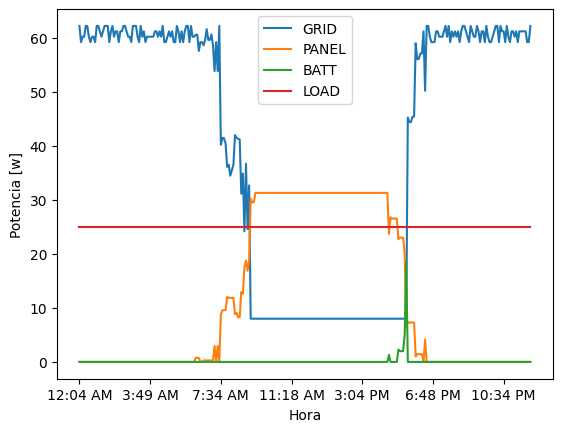

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [58]:
etiquetas_xticks = [Time[n] for n in range(len(Time)) if n % 45 == 0]

plt.plot(Time,PowerGrid_a)
plt.plot(PanelPower_a)
plt.plot(PowerBatt_a)
plt.plot(TotalLoad_a)
plt.legend(["GRID","PANEL","BATT","LOAD"])
plt.xlabel('Hora')
plt.ylabel('Potencia [w]')
plt.xticks(etiquetas_xticks)

# Utilizar los mismos valores para las etiquetas
plt.show()
print(State_a)
#Unidades - Vatios y Horas/Segundos.
